# Word embeddings for ingredient lists

When developing product classification, it appeared that existing embeddings did not work for us. What about creating our own embedding? Here we start on with experiment on ingredient lists.

See also: [gensim](https://github.com/rare-technologies/gensim) with examples on [word2vec](https://github.com/RaRe-Technologies/gensim/blob/21ef524cc0f2703e9a055110061fd95da9a1f18b/docs/notebooks/word2vec.ipynb), [applied to wikipedia](https://github.com/RaRe-Technologies/gensim/blob/21ef524cc0f2703e9a055110061fd95da9a1f18b/docs/notebooks/doc2vec-wikipedia.ipynb), [gensim word2vec tutorial](http://adventuresinmachinelearning.com/gensim-word2vec-tutorial/) and [gensim with keras](https://github.com/niitsuma/word2vec-keras-in-gensim).

In [2]:
import json
import logging
import nltk
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from pprint import pprint

# download source file from https://github.com/q-m/food-ingredient-parser-ruby/data/
filename_source_data = 'ingredient-samples-qm-nl'
# output model filename
filename_model       = 'gensim.model'

nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('dutch') + '''
  ca bijv bijvoorbeeld
  gemaakt aanbevolen
  belangrijk belangrijke heerlijk heerlijke handig handige dagelijks dagelijkse
  gebruik allergieinformatie bijdrage smaak hoeveelheid
'''.split()

logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

[nltk_data] Downloading package stopwords to
[nltk_data]     ~/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing text

First we need to extract tokens (words) from the input text.

In [3]:
import re
from unidecode import unidecode

def preprocess_text(s):
    if s is None: return None
    
    s = unidecode(s).strip()
    s = re.sub(r'[^A-Za-z\'\s]', '', s, flags=re.MULTILINE)
    s = re.sub(r'(\s|\\n)+', ' ', s, flags=re.MULTILINE)
    s = s.lower()
    
    return s

def get_ingredient_tokens(s):
    s = preprocess_text(s)
    tokens = [s.strip() for s in s.split()]
    tokens = [t for t in tokens if t != '']
    tokens = [t for t in tokens if not re.match(r'^\s*[0-9,.]*[0-9]+\s*%?\s*$', t)]
    tokens = [t for t in tokens if t not in STOPWORDS]
    if len(tokens) == 0: return None
    return tokens    

def get_tokens(s):
    return get_ingredient_tokens(s)

data = []
with open(filename_source_data) as f:
    for line in f:
        d = get_tokens(line)
        if d: data.append(d)

sample_id = 22
print("Sample %d of %d:\n%s"%(sample_id, len(data), data[sample_id]))

Sample 22 of 147922:
['amandelen']


## Training

Then the model is trained with the input data.

In [4]:
class TaggedDocuments(object):
    def __init__(self, data):
        self.data = data
    def __iter__(self):
        for i, d in enumerate(self.data):
            yield TaggedDocument(d, [i])

docs = TaggedDocuments(data)

In [5]:
import multiprocessing
cores = multiprocessing.cpu_count()

epochs = 5 # 20
min_count = 8
vector_size = 200

model = Doc2Vec(dm=0, dbow_words=1, vector_size=vector_size, window=8, min_count=min_count, epochs=epochs, workers=cores)
#model = Doc2Vec(dm=1, dm_mean=1, vector_size=vector_size, window=12, min_count=min_count, epochs=epochs, workers=cores)

print(str(model))
model.build_vocab(docs)
model.train(docs, total_examples=model.corpus_count, epochs=model.epochs)
model.save(filename_model)

INFO: collecting all words and their counts
INFO: PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO: PROGRESS: at example #10000, processed 281916 words (2216653/s), 7919 word types, 10000 tags


Doc2Vec(dbow+w,d200,n5,w8,mc8,s0.001,t4)


INFO: PROGRESS: at example #20000, processed 508037 words (2078449/s), 12757 word types, 20000 tags
INFO: PROGRESS: at example #30000, processed 715462 words (1948791/s), 18638 word types, 30000 tags
INFO: PROGRESS: at example #40000, processed 953834 words (1818286/s), 22263 word types, 40000 tags
INFO: PROGRESS: at example #50000, processed 1211474 words (2183007/s), 26520 word types, 50000 tags
INFO: PROGRESS: at example #60000, processed 1453935 words (2422587/s), 30664 word types, 60000 tags
INFO: PROGRESS: at example #70000, processed 1718252 words (2500659/s), 34793 word types, 70000 tags
INFO: PROGRESS: at example #80000, processed 1995315 words (2820933/s), 38563 word types, 80000 tags
INFO: PROGRESS: at example #90000, processed 2221099 words (3126399/s), 42610 word types, 90000 tags
INFO: PROGRESS: at example #100000, processed 2436319 words (2894979/s), 45055 word types, 100000 tags
INFO: PROGRESS: at example #110000, processed 2647775 words (2724966/s), 47546 word types, 1

INFO: EPOCH 4 - PROGRESS: at 15.73% examples, 143770 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 4 - PROGRESS: at 23.01% examples, 152784 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 4 - PROGRESS: at 28.29% examples, 156164 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 4 - PROGRESS: at 34.73% examples, 159125 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 4 - PROGRESS: at 40.30% examples, 157778 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 4 - PROGRESS: at 45.33% examples, 155580 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 4 - PROGRESS: at 50.94% examples, 157028 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 4 - PROGRESS: at 56.98% examples, 158453 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 4 - PROGRESS: at 63.27% examples, 157245 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 4 - PROGRESS: at 70.42% examples, 159104 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 4 - PROGRESS: at 76.25% examples, 158859 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 4 - PROGRESS: at 82.44% examples, 160488 w

INFO: EPOCH 8 - PROGRESS: at 38.84% examples, 115370 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 8 - PROGRESS: at 46.46% examples, 125013 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 8 - PROGRESS: at 52.01% examples, 129186 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 8 - PROGRESS: at 57.33% examples, 130408 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 8 - PROGRESS: at 60.91% examples, 125298 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 8 - PROGRESS: at 63.89% examples, 121672 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 8 - PROGRESS: at 67.02% examples, 118627 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 8 - PROGRESS: at 72.16% examples, 119059 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 8 - PROGRESS: at 77.98% examples, 120716 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 8 - PROGRESS: at 81.99% examples, 121111 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 8 - PROGRESS: at 87.68% examples, 122557 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 8 - PROGRESS: at 90.69% examples, 120569 w

INFO: EPOCH 13 - PROGRESS: at 33.66% examples, 185058 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 13 - PROGRESS: at 38.46% examples, 174995 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 13 - PROGRESS: at 45.33% examples, 177735 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 13 - PROGRESS: at 50.36% examples, 175408 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 13 - PROGRESS: at 57.66% examples, 176156 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 13 - PROGRESS: at 65.25% examples, 175606 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 13 - PROGRESS: at 70.99% examples, 173487 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 13 - PROGRESS: at 75.98% examples, 169753 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 13 - PROGRESS: at 81.02% examples, 168345 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 13 - PROGRESS: at 86.57% examples, 165589 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 13 - PROGRESS: at 93.75% examples, 166642 words/s, in_qsize 8, out_qsize 0
INFO: worker thread finished; awaiting fini

INFO: EPOCH 18 - PROGRESS: at 45.07% examples, 150263 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 18 - PROGRESS: at 51.28% examples, 154240 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 18 - PROGRESS: at 58.40% examples, 158047 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 18 - PROGRESS: at 65.67% examples, 160325 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 18 - PROGRESS: at 70.69% examples, 157207 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 18 - PROGRESS: at 77.09% examples, 158147 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 18 - PROGRESS: at 81.99% examples, 157444 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 18 - PROGRESS: at 88.60% examples, 158426 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 18 - PROGRESS: at 93.50% examples, 157358 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 18 - PROGRESS: at 98.26% examples, 155636 words/s, in_qsize 5, out_qsize 0
INFO: worker thread finished; awaiting finish of 3 more threads
INFO: worker thread finished; awaiting finish of 2 more threads
IN

INFO: EPOCH 23 - PROGRESS: at 5.13% examples, 155947 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 23 - PROGRESS: at 9.93% examples, 141779 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 23 - PROGRESS: at 17.04% examples, 159145 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 23 - PROGRESS: at 21.87% examples, 146865 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 23 - PROGRESS: at 24.57% examples, 131248 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 23 - PROGRESS: at 27.62% examples, 125067 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 23 - PROGRESS: at 30.99% examples, 123118 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 23 - PROGRESS: at 35.95% examples, 124045 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 23 - PROGRESS: at 40.82% examples, 124492 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 23 - PROGRESS: at 45.07% examples, 123470 words/s, in_qsize 7, out_qsize 0
INFO: EPOCH 23 - PROGRESS: at 50.10% examples, 126877 words/s, in_qsize 8, out_qsize 0
INFO: EPOCH 23 - PROGRESS: at 55.42% examples

# Using the model

Now that we have a model, let's look at what it can do.

## Similar ingredient lists

In [6]:
test_id=2345
print()
print(str(model))
print(' '.join(data[test_id]))
for i,p in model.docvecs.most_similar(positive=[test_id], topn=12):
    print("%.2f: %s"%(p, ' '.join(data[i])))

INFO: precomputing L2-norms of doc weight vectors



Doc2Vec(dbow+w,d200,n5,w8,mc8,s0.001,t4)
kastanje champignons witte champignons oesterzwammen wilde paddenstoelen bieslook
0.89: witte champignons shiitake oesterzwammen
0.87: ingredienten shiitake champignons kastanjechampignons oesterzwammen beukenzwamen
0.85: ingredienten eekhoorntjesbrood oesterzwammen shiitake ringboleten
0.84: kastanje champignons
0.84: eekhoorntjesbrood oesterzwammen shiitake ringboleten
0.83: eekhoorntjesbrood porcini oesterzwammen shiitake ringboleten
0.83: ingredienten kastanje champignons
0.83: ingredienten oesterzwammen shiitake bundelzwammen eekhoorntjesbrood
0.83: oesterzwammen shiitake bundelzwammen eekhoorntjesbrood
0.83: ingredienten champignons gesneden oesterzwammen shiitake bundelzwammen
0.82: ingredienten kastanje champignons
0.82: ingredienten oesterzwammen


gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Similar words

The model knows about similar words. Let's look at some.

In [7]:
for w in ['kip', 'rund', 'peper', 'noten', 'bolletje' ,'aspartaam']:
    print("Most similar to:", w)
    print([p[0] for p in model.wv.most_similar(w)[0:7] if p[1] > 0.45])

INFO: precomputing L2-norms of word weight vectors


Most similar to: kip
['kippenvlees', 'kalkoen', 'gegaarde', 'diervoeder', 'suikernnmet', 'kipfilet', 'lam']
Most similar to: rund
['varken', 'kalf', 'runderhart', 'mineralennmet', 'samenstellingnvlees', 'gistnnmet', 'samenstellingngranen']
Most similar to: peper
['knoflook', 'chilipeper', 'nootmuskaat', 'kruiden', 'peterselie', 'koriander', 'ui']
Most similar to: noten
['sesam', 'sporen', 'bevatten', "pinda's", 'waar', 'pindas', 'geproduceerd']
Most similar to: bolletje
['ingredientenvolkorentarwemeel', 'stokbrood', 'ingredientennrozijnen', 'hopextrakt', 'zuurdesemtarwerogge', 'gesorteerd', 'ingredientenntarwemeel']
Most similar to: aspartaam
['acesulfaamk', 'fenylalanine', 'bron', 'zoetstoffen', 'acesulfaam', 'fenylalaline', 'cyclamaten']


gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


We can also plot similar words, using code from [this page](https://ireneli.eu/2016/07/27/nlp-05-from-word2vec-to-doc2vec-a-simple-example-with-gensim/).

Added 60 words. Shape (60, 200)


gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


<IPython.core.display.Javascript object>


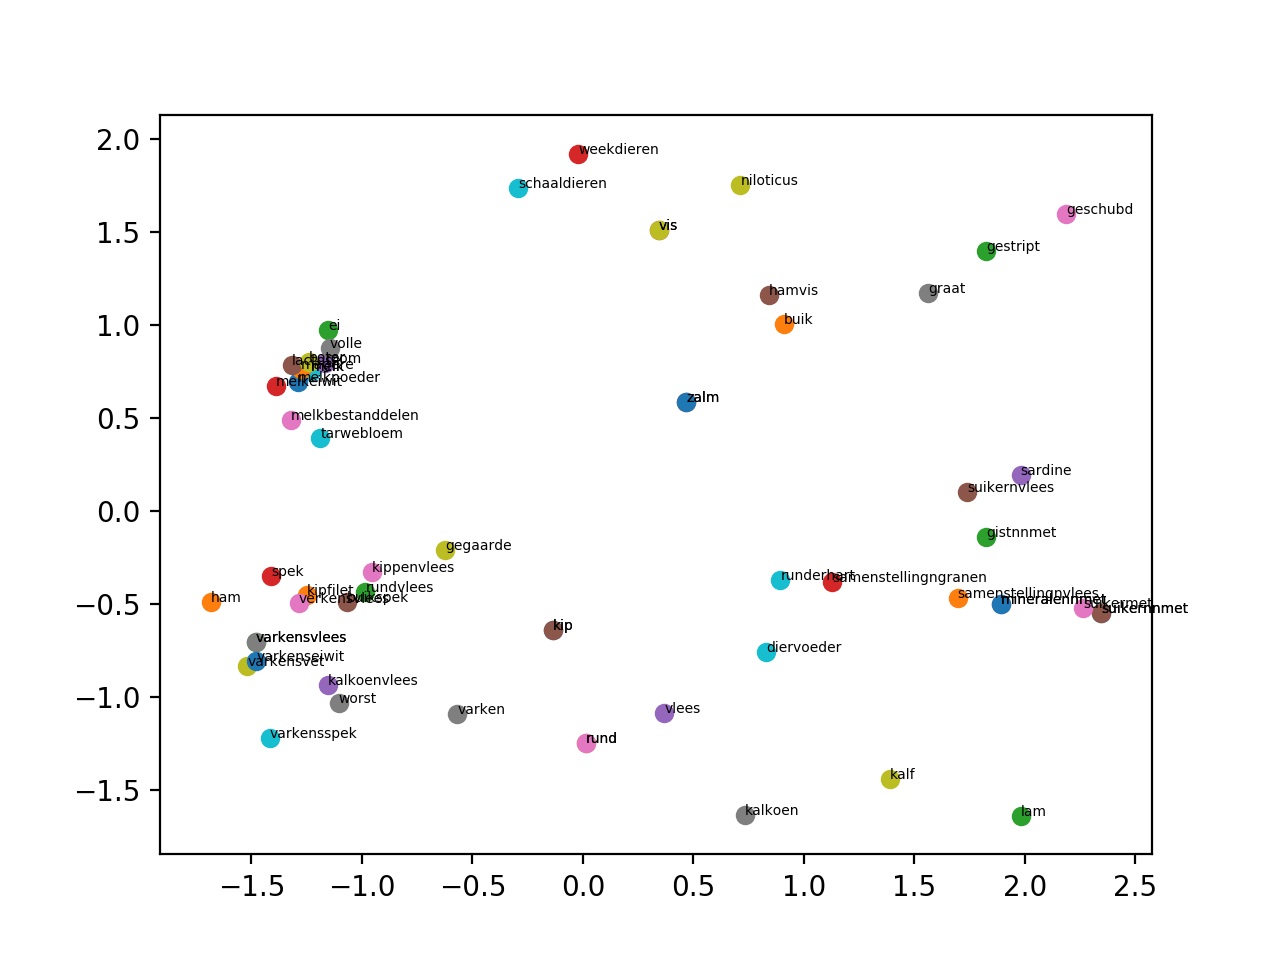

In [64]:
import matplotlib.pyplot as plt
%matplotlib notebook
   
from sklearn.decomposition import PCA
def display_closestwords_pca(model, words_in):
    words = [] + words_in
    
    for w in words_in:
        words = words + [w] + [o[0] for o in model.wv.similar_by_word(w)]
    
    words_np, words_label = [], []
    for w in words:
        words_np.append(model[w])
        words_label.append(w)
    print('Added %s words. Shape %s'%(len(words_np),np.shape(words_np)))
 
    pca = PCA(n_components=2)
    pca.fit(words_np)
    reduced = pca.transform(words_np)
 
    # plt.plot(pca.explained_variance_ratio_)
    for index,vec in enumerate(reduced):
        # print ('%s %s'%(words_label[index],vec))
        if index <100:
            x,y=vec[0],vec[1]
            plt.scatter(x,y)
            plt.annotate(words_label[index],xy=(x,y),fontsize='5')
    plt.show()

display_closestwords_pca(model, ['kip', 'rund', 'varkensvlees', 'vis', 'melk'])

## Computations with words

Let's have a look at how words relate.
As nut (_noten_) is to peanut (_pinda_), cheese (_kaas_) is to ... _mozarella_ and _edammer_ (which are varieties of cheese). That seems close.

In [69]:
model.wv.similar_by_vector(model['noten'] - model['pinda'] + model['kaas'])

gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('kaas', 0.6632275581359863),
 ('stremsel', 0.4258827567100525),
 ('zuursel', 0.4227018356323242),
 ('mozzarella', 0.4157063961029053),
 ('emmentaler', 0.41169965267181396),
 ('mimolette', 0.3891027867794037),
 ('noten', 0.3777956962585449),
 ('gouda', 0.3750431537628174),
 ('aop', 0.37082400918006897),
 ('goudse', 0.3652280569076538)]

As cheese (_kaas_) is to rennet (_stremsel_), so tofu is to ... calcium sulfate (_calciumsulfaat_) and _nigari_ (which are coagulants). Wow, that is indeed a similar relationship!

Now cheese and yeast have similar probabilities, so to what extend this data is really usable remains a question, but it is interesting nonetheless.

In [62]:
model.wv.similar_by_vector(model['kaas'] - model['stremsel'] + model['tofu'])

gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('tofu', 0.889039933681488),
 ('nigari', 0.5748956203460693),
 ('calciumsulfaat', 0.5171441435813904),
 ('shoyu', 0.48386281728744507),
 ('seitan', 0.4323842525482178),
 ('voedingsgist', 0.4270457625389099),
 ('stollingsmiddel', 0.40027934312820435),
 ('sojavezels', 0.3898795247077942),
 ('koudgeperste', 0.3683256506919861),
 ('sojayoghurt', 0.36792898178100586)]

## Inside the embedding

Let's see if we can derive some meaning from the embedding.
That doesn't seem to work.

In [80]:
from functools import reduce

def idxs(ings, d=-2):
    ingsv = [model[ing] for ing in ings]
    ingsv = reduce(lambda x,y: x*y, ingsv)
    return np.where(ingsv > 10 ** -(len(ings)+d))[0]

print("Nuts:   ", idxs(['noot', 'pinda', 'amandel', 'walnoot', 'cashewnoot', 'macadamia',
                        'noten', "pinda's", 'amandel', 'aardnoten', 'walnoten', 'cashewnoten', "macadamia's"], -5))
print("Milk:   ", idxs(['melk', 'karnemelk', 'halfvolle', 'volle', 'magere'], -2))
print("Spices: ", idxs(['peper', 'kardemom', 'nootmuskaat', 'piment', 'paprikapoeder']) )
print("Salt:   ", idxs(['zout', 'zeezout', 'himalayazout', 'tafelzout', 'nacl', 'natriumchloride'], -3))

Nuts:    [ 77 119 121 130 176 191 192]
Milk:    [ 48 175]
Spices:  [ 73  96 113 116 177]
Salt:    [ 27  50  53 141 180]
